# L02 - Introduction to FEniCS - Diffusion


<img style="float: left;" src="fig/fenics_logo.png" width=200>


 In this notebook, we will cover the implementation and solving of a simple diffusion problem using the Finite Element tool FEniCS. You will learn how to: 
 - Derive the variational form of the problem and implement it in FEniCS
 - Build and solve a 1D steady state diffusion problem
 - Play with the diffusion coefficient and the source term
 - Build and solve a 1D transient diffusion problem
 - Do all the same in 2D
 

The FEniCS project is a collection of software designed for the automated solution of partial differential equations using the finite element method. It handles a lot of the busywork involved for you, and more or less automates everything except the mathematical derivation of the problem (strong  and weak formulations). Both Python and C++ interfaces exist. It can be obtained at https://fenicsproject.org/download/.
The community around the FEniCS project is very active and a lot of useful informations and demo files can be found from the tutorial webpage o teh project. I recommend each of you to download the free tutorial book "Solving PDE's in Python - The FEniCS Tutorial I" (https://fenicsproject.org/tutorial/). It covers most of the python functionability of FEniCS and is a good starting for any one who wants to use FEniCS.

In [4]:
from IPython.display import IFrame, HTML
HTML('<iframe src=https://fenicsproject.org/tutorial/ width=900 height=1000></iframe>')

# Diffusion equation
 
The diffusion equation is an fundamental equation used to describe many natural processes. It applies well to quantify smooth and "diffuse" transport processes. It is used to describe scalar field such as temperature (transport of heat by thermal conduction, Fourier's law) or concentration (calcium concentration in cells, Fick's law).
Let's assume a scalar field $U_{(t,x)}$, depending on time and space, the diffusion process of $U$ can be approximated by the following partial differential equation: 

$$ \frac {\partial U} {\partial t} - \nabla \cdot \kappa \: \nabla U = S$$ 

Equivalent to :

$$  \frac {\partial U} {\partial t} - \nabla \cdot \kappa \: ( \frac {\partial U} {\partial x}, \frac {\partial U} {\partial y}, \frac {\partial U} {\partial z}) = S $$ 


Where $S$ is a source term. When the diffusion coefficient $\kappa$ is constant in space, the equation can be rearranged as follow:


$$  \frac {\partial U} {\partial t} - \kappa \: (\frac {\partial^2 U} {\partial x^2} + \frac {\partial^2 U} {\partial y^2} + \frac {\partial^2 U} {\partial z^2} ) = S $$ 




# Solving a 1D steady state diffusion problem 

In this example, we will solve the diffusion equation in its simpliest form assuming a one dimensional problem (along the x-axis) and steady state condition, when the time derivative vanishes to zero $\frac {\partial U} {\partial t} = 0$. 

The equation becomes: 


$$ - \: \kappa \: \frac {\partial^2 U} {\partial x^2}  = \: S $$ 

These simplification leads to the formulation of a Poisson problem as solved step by step in the "introduction to Finite Elements" course.

In order to solve the problem using FEniCS, one has to apply the "FEM recipe" to express the partial differential equation into a variation problem.


### Turning the pde into a variational problem

As before, we start out by deriving the weak form of our problem. We do this by multiplying by a test function $V$, integrating over the whole domain, and manipulating the integral using integration by parts until no second derivatives occur. 


$$- \: \int \limits_\Omega  \: \Bigl(\kappa \: \frac {\partial^2 U} {\partial x^2}\Bigr) V \: \text{dx} = \int  \limits_\Omega  S \: V \: \text{dx}$$ 

Intergration by parts formula:

$$ - \: \int \limits_\Omega \: \Bigl(\frac {\partial^2 A} {\partial x^2}\Bigr) B  \: \text{dx} = \int \limits_\Omega \: \frac {\partial A} {\partial x} \frac {\partial B} {\partial x} \text{dx} \: - \: \int \limits_{\partial \Omega} \frac {\partial A} {\partial x} B \: \text{ds} $$ 


Applied to our equation, we obtain:

$$ \: \int  \limits_\Omega  \: \kappa \: \frac {\partial U} {\partial x} \frac {\partial V} {\partial x} \: \text{dx} = \int  \limits_\Omega  S \: V \: \text{dx}\: + \: \int \limits_{\partial \Omega} \frac {\partial U} {\partial x} V \: \text{ds}  $$ 


As this has no second derivatives, this is the weak form of our equation.



### FEniCS: First, import the library
Once FEniCS is properly installed, you can start using it in a Python program by importing the DOLFIN module:

In [2]:
# DOLFIN is the computational backend of the FEniCS project
from dolfin import * 

### FEniCS: Discretizing the domain and space of functions
We can now use FEniCS to solve our problem. First, we discretize our domain by creating a mesh within the domain $\Omega$ bounded from 0 to 1. 

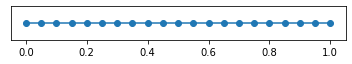

In [10]:
mesh = UnitIntervalMesh(20) # 20 is number of intervals Omega is divided intoc
plot(mesh);


Next, choose a space of functions to use for approximating $U$. We use the space of continuous piecewise linear functions on our mesh. Denote this space by $W$.

In [11]:
elem = FiniteElement("CG", interval, 1) # here interval is a FEniCS builtin representing a single interval
W = FunctionSpace(mesh, elem)

Think of `elem` as a function space of linear functions living on a single subinterval of our mesh. The call to `FunctionSpace` then takes this small 'model' function space living in a single subinterval of the mesh and builds a 'global' function space $W$ by effectively gluing together copies of `elem`. This is not 100% accurate, but a good mental picture.


### FEniCS: Specifying the weak formulation
We need to tell FEniCS the weak formulation of our problem.

In [12]:
kappa = Constant(1.0)

V = TestFunction(W) # the test function
U = TrialFunction(W) # the TrialFunction is basically a symbol representing the unknown

a = kappa * dot( grad(U), grad(V) ) * dx  # left hand side of our equation
S = Constant(0.0) # source term
L = (S*V) * dx # right hand side of our equation

Don't be confused! The left hand side (lhs) and the right hand side (rhs) of the equation is often called a and L, respectively, in the FEniCS demos. To stay consistent with the tutorial book, we will adopt these notations in this notebook. 


### FEniCS: Specifying boundary conditions
There are different types of boundary conditions that we can apply  to the limits of our model. Namely, Dirichlet (or strong), Neumann (or natural), and Robin boundary conditions. For the moment, we will only applied Dirichlet boundary conditions in our model, meaning that we will explicitly set the boundary values in our system of equations, let's say $U_0=0$ and $U_1=2$. More details are given a the end of the notebook to explain the implementation of Dirichlet boundary conditions on the system of equations. 

Note that when Dirichlet boundary conditions are applied, the boundary term in our equation $\int \limits_{\partial \Omega} \frac {\partial U} {\partial x} V \: \text{ds}  $ can be ignored. This is a nice fact coming out of the Finite Elements formulation.

In [15]:
value_left = Constant(0.0)
value_right = Constant(20.0)
bc_l = DirichletBC(W, value_left, "on_boundary && near(x[0], 0)") # Imposing Dirichlet BC to the left boundary node
bc_r = DirichletBC(W, value_right, "on_boundary && near(x[0], 1)") # Imposing Dirichlet BC to the right boundary node
bcs = [bc_l, bc_r]   # list of boundary conditions to apply to the problem

To impose the Dirichlet boundary conditon we use the FEniCS object 'DirichletBC'. The first argument is the function space on which we approximate our function, the second argument is the value we want to impose, and the last argument is where the boundary condition should apply.

Now we have done basically all we need to do to solve our problem.


### FEniCS: Solving


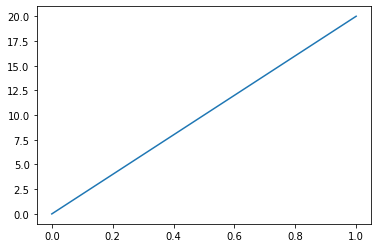

In [16]:
U_sol = Function(W)  # place to store the solution
solve(a == L, U_sol, bcs)
plot(U_sol);

And that's it! We have solved a PDE in less than 20 lines of code. That's pretty good value for money. The same procedure can be carried through for more complicated equations as well. Though a bit more code may be required to specify the domains, boundaries and weak forms, the overall structure is still the same:

1. Define the domain
2. Define the `FunctionSpace` you want to use for approximating your solution
3. Specify the weak form so FEniCS understands it
4. Specify the boundary conditions
5. Solve

### Exercice 1: Playing with the diffusion coeffient
Assuming that the coefficient $\kappa$ is element-wise constant, set a differente value of the constant in the middle of the domain. 


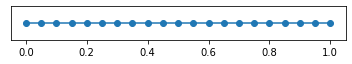

In [17]:
mesh = UnitIntervalMesh(20) # 20 is number of intervals Omega is divided intoc
plot(mesh);

elem = FiniteElement("CG", interval, 1) # here interval is a FEniCS builtin representing a single interval
W = FunctionSpace(mesh, elem)

In [24]:
#kappa = Constant(1.0)
k_elem = FiniteElement("DG", interval, 0)
kappa_e = Function(FunctionSpace(mesh, k_elem))
kappa_e.vector()[:]=1
kappa_e.vector()[9]=20
kappa_e.vector()[:]


array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 20.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.])

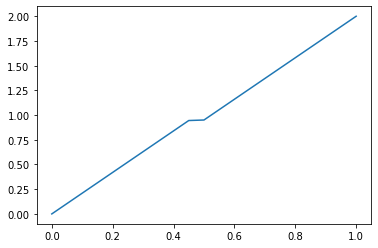

In [25]:
V = TestFunction(W) # the test function
U = TrialFunction(W) # the TrialFunction is basically a symbol representing the unknown

a = kappa_e * dot( grad(U), grad(V) ) * dx  # left hand side of our equation
S = Constant(0.0) # source term
L = (S*V) * dx # right hand side of our equation

value_left = Constant(0.0)
value_right = Constant(2.0)
bc_l = DirichletBC(W, value_left, "on_boundary && near(x[0], 0)") # Imposing Dirichlet BC to the left boundary node
bc_r = DirichletBC(W, value_right, "on_boundary && near(x[0], 1)") # Imposing Dirichlet BC to the right boundary node
bcs = [bc_l, bc_r]   # list of boundary conditions to apply to the problem

U_sol = Function(W)  # place to store the solution
solve(a == L, U_sol, bcs) # solve the problem
plot(U_sol);


### Exercice 2: Playing with the source term
Let's do the same with the source term. Let's include a source term of the given value at the same element within the domain. 



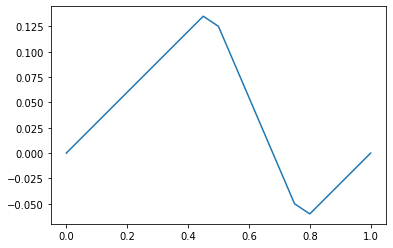

In [34]:
#S = Constant(0.0) # source term
s_elem = FiniteElement("DG", interval, 0)
S_e = Function(FunctionSpace(mesh, s_elem))
S_e.vector()[:]=0
S_e.vector()[9]=20
S_e.vector()[15]=-20
S_e.vector()[:]


L = (S_e*V) * dx # right hand side of our equation

value_left = Constant(0.0)
value_right = Constant(0.0)
bc_l = DirichletBC(W, value_left, "on_boundary && near(x[0], 0)") # Imposing Dirichlet BC to the left boundary node
bc_r = DirichletBC(W, value_right, "on_boundary && near(x[0], 1)") # Imposing Dirichlet BC to the right boundary node
bcs = [bc_l, bc_r]   # list of boundary conditions to apply to the problem

U_sol = Function(W)  # place to store the solution
solve(a == L, U_sol, bcs) # solve the problem
plot(U_sol);

# Solving a 1D transient diffusion problem 

Now that we succefully solved the diffusion equation for steady state conditions, let's look at the time evolution of the solution before equilibrium is reached.

In this case, the equation is: 

$$ \frac {\partial U} {\partial t}  - \: \kappa \: \frac {\partial^2 U} {\partial^2 x}  = \: S $$ 

One classical approach of evaluating the time derivative term is to approximate it by means of finite differences.The following backward Euler scheme can be used: 

$$ \frac {\partial U} {\partial t} = \frac {U^{new} - U^{old}}{dt} $$ 


### Turning the pde into a variational form

As before, we express the variational form of our problem with the approximated time derivation term: 


$$\int \limits_{\Omega}  \Bigl(\frac {U - U^{old}}{dt}\Bigr) \: V \: \text{dx}  + \int  \limits_{\Omega} \: \kappa \: \frac {\partial U} {\partial x} \frac {\partial V} {\partial x} \: \text{dx} = \int  \limits_{\Omega} S \: V \: \text{dx} + \: \int \limits_{\partial \Omega} \frac {\partial U} {\partial x} V \: \text{ds}    $$ 

One can rearrange the equation in a way that all the unknown terms are present in the left hand side and all the known terms present in the right hand side. 

$$\int \limits_{\Omega}  \frac {1}{dt} U \: V \: \text{dx}  + \int  \limits_{\Omega} \: \kappa \: \frac {\partial U} {\partial x} \frac {\partial V} {\partial x} \: \text{dx} = \int \limits_{\Omega}  \frac {1}{dt} U^{old} \: V \: \text{dx}  + \int  \limits_{\Omega} S \: V \: \text{dx}  + \: \int \limits_{\partial \Omega} \frac {\partial U} {\partial x} V \: \text{ds}  $$ 



### FEniCS: Let's start as before



We first need to discretize our domain into a FE mesh.

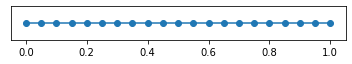

In [226]:
## your code here!

We have introduced two new variables:
- `dt`, the time step, which is a `Constant` object that appear in both the righ hand side (`a`) and left hend side (`L`) form. 
- `nb_t`, that we will use to constrain the maximum number of time steps to run.

### FEniCS: Time loop

Since we want to look at the time evolution of the diffusion process, we need to solve the problem step by step within a **time loop** and update the solution over the time step `dt`.

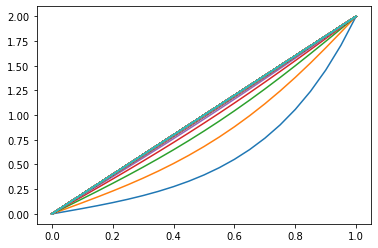

In [228]:
for t in range(nb_t):
    #
    # Write the necessary code lines to solve the system of equations!
    #
    assign(U_old, U_sol)  # update the old solution to the new one for next time step 

**NOTE:** When defining the function `U_old` in the variational form, FEniCS will automatically take into account the updated values in the system of equations when we execute `assign(U_old, U_sol)`.   
    

# Solving a transient 2D diffusion problem 
Adding an extra dimension is easy! Let's start from the equation and follow the same procedure as in the previous cases. 

$$ \frac {\partial U} {\partial t}  - \: \kappa \: \Bigl(\frac {\partial^2 U} {\partial^2 x} +  \frac {\partial^2 U} {\partial^2 z}\Bigr)  = \: S $$ 


### Turning the pde into a variational problem

$$\int \limits_{\Omega} \Bigl(\frac {U - U^{old}}{dt}\Bigr) \: V \: \text{dx}  + \int  \limits_{\Omega} \: \kappa \:  \Bigl(\frac {\partial U} {\partial x} \frac {\partial V} {\partial x} + \frac {\partial U} {\partial y} \frac {\partial V} {\partial y}\Bigr) \: \text{dx} = \int  \limits_{\Omega} S \: V \: \text{dx}  + \: \int \limits_{\partial \Omega} \frac {\partial U} {\partial x} V \: \text{ds} + \: \int \limits_{\partial \Omega} \frac {\partial U} {\partial y} V \: \text{ds} $$ 


Once we rearrange the unknown terms in the left hand side and the known terms in the right hand side, we obtain:

$$\int \limits_{\Omega}  \frac {1}{dt} U \: V \: \text{dx}  + \int  \limits_{\Omega} \: \kappa \: \Bigl( \frac {\partial U} {\partial x}  \frac {\partial V} {\partial x} + \frac {\partial U} {\partial y} \frac {\partial V} {\partial y}\Bigr) \: \text{dx} = \int \limits_{\Omega}  \frac {1}{dt} U^{old} \: V \: \text{dx}  + \int  \limits_{\Omega} S \: V \: \text{dx}  + \: \int \limits_{\partial \Omega} \frac {\partial U} {\partial x} V \: \text{ds} + \: \int \limits_{\partial \Omega} \frac {\partial U} {\partial y} V \: \text{ds}   $$ 




### FEniCS: Moving to 2D
Adding the second dimension is straight forward using FEniCS. Only minor changes have to made on defining the mesh, the `FunctionSpace`, and the boundaries of the 2D domain. 


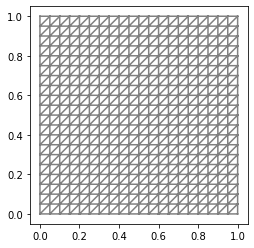

In [35]:
mesh = UnitSquareMesh(20,20) # 20 is number of intervals Omega is divided into
plot(mesh);

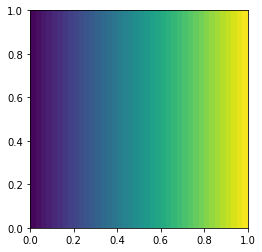

In [37]:
# Based on the previous 1D code, make your own 2D code
elem = FiniteElement("CG", triangle, 1) # here interval is a FEniCS builtin representing a single interval
W = FunctionSpace(mesh, elem)

kappa = Constant(1.0)
S = Constant(0.0)

V = TestFunction(W) # the test function
U = TrialFunction(W) # the TrialFunction is basically a symbol representing the unknown

a = kappa * dot( grad(U), grad(V) ) * dx  # left hand side of our equation
S = Constant(0.0) # source term
L = (S*V) * dx # right hand side of our equation

value_left = Constant(0.0)
value_right = Constant(2.0)
bc_l = DirichletBC(W, value_left, "on_boundary && near(x[0], 0)") # Imposing Dirichlet BC to the left boundary node
bc_r = DirichletBC(W, value_right, "on_boundary && near(x[0], 1)") # Imposing Dirichlet BC to the right boundary node
bcs = [bc_l, bc_r]   # list of boundary conditions to apply to the problem

U_sol = Function(W)  # place to store the solution
solve(a == L, U_sol, bcs) # solve the problem
plot(U_sol);



**Well done!**

# Where did the boundary terms go, and when can I ignore them? (extra)
To make it clear what is happening with the boundary terms we ignored, what FEniCS does behind the scenes is the following:

In [231]:
mesh = UnitIntervalMesh(5) # 20 is number of intervals Omega is divided intoc
elem = FiniteElement("CG", interval, 1) # here interval is a FEniCS builtin representing a single interval
W = FunctionSpace(mesh, elem)

V = TestFunction(W) # the test function
U = TrialFunction(W) # the TrialFunction is basically a symbol representing the unknown

kappa = Constant(1.0)
a = kappa * dot( grad(U), grad(V) ) * dx  # left hand side of our equation
S = Constant(0.0) # source term
L = (S*V) * dx # right hand side of our equation

value_left = Constant(0.0)
value_right = Constant(2.0)
bc_l = DirichletBC(W, value_left, "on_boundary && near(x[0], 0)") # Imposing Dirichlet BC to the left boundary node
bc_r = DirichletBC(W, value_right, "on_boundary && near(x[0], 1)") # Imposing Dirichlet BC to the right boundary node

A = assemble(a)
b = assemble(L)


In [232]:
print("\nBefore BCs are applied without bdy term: \n")
from sympy import init_printing, Matrix, Eq
init_printing(use_latex = 'mathjax') # Used to print Latex to the screen
%matplotlib inline

(Matrix(A.array()), Matrix(b.get_local()))



Before BCs are applied without bdy term: 



⎛⎡5.0   -5.0  0.0   0.0   0.0   0.0 ⎤  ⎡0.0⎤⎞
⎜⎢                                  ⎥  ⎢   ⎥⎟
⎜⎢-5.0  10.0  -5.0  0.0   0.0   0.0 ⎥  ⎢0.0⎥⎟
⎜⎢                                  ⎥  ⎢   ⎥⎟
⎜⎢0.0   -5.0  10.0  -5.0  0.0   0.0 ⎥  ⎢0.0⎥⎟
⎜⎢                                  ⎥, ⎢   ⎥⎟
⎜⎢0.0   0.0   -5.0  10.0  -5.0  0.0 ⎥  ⎢0.0⎥⎟
⎜⎢                                  ⎥  ⎢   ⎥⎟
⎜⎢0.0   0.0   0.0   -5.0  10.0  -5.0⎥  ⎢0.0⎥⎟
⎜⎢                                  ⎥  ⎢   ⎥⎟
⎝⎣0.0   0.0   0.0   0.0   -5.0  5.0 ⎦  ⎣0.0⎦⎠

In [233]:
bc_l.apply(A)
bc_r.apply(A)
bc_l.apply(b)
bc_r.apply(b)

print("\nAfter BCs are applied without bdy term: \n")

(Matrix(A.array()), Matrix(b.get_local()))


After BCs are applied without bdy term: 



⎛⎡1.0   0.0   0.0   0.0   0.0   0.0 ⎤  ⎡2.0⎤⎞
⎜⎢                                  ⎥  ⎢   ⎥⎟
⎜⎢-5.0  10.0  -5.0  0.0   0.0   0.0 ⎥  ⎢0.0⎥⎟
⎜⎢                                  ⎥  ⎢   ⎥⎟
⎜⎢0.0   -5.0  10.0  -5.0  0.0   0.0 ⎥  ⎢0.0⎥⎟
⎜⎢                                  ⎥, ⎢   ⎥⎟
⎜⎢0.0   0.0   -5.0  10.0  -5.0  0.0 ⎥  ⎢0.0⎥⎟
⎜⎢                                  ⎥  ⎢   ⎥⎟
⎜⎢0.0   0.0   0.0   -5.0  10.0  -5.0⎥  ⎢0.0⎥⎟
⎜⎢                                  ⎥  ⎢   ⎥⎟
⎝⎣0.0   0.0   0.0   0.0   0.0   1.0 ⎦  ⎣0.0⎦⎠

This tells you how `DirichletBC`s are applied in FEniCS, and why adding the boundary terms wouldn't matter. When you give FEniCS a boundary condition, it replaces the equation it got from putting $V=\phi_i$ for the right $i$ by one reading $u_i = $ the value $U$ is supposed to have there, meaning a row of $A$ is replaced by one with a single 1 and the rest 0, and the correponding part of $b$ set to the right value.

Note that you are only allowed to ignore the boundary terms when you have a boundary condition of the form $U = $ constant at every part of the boundary. Such boundary conditions are called *Dirichlet* boundary conditions. Sometimes you might have conditions involving the derivative of $U$ instead. Those are called *Neumann* or *Robin* boundary conditions, and generally mean you have to add a term to `rhs`. 

If you had wanted to add boundary terms, this could be done as follows:

In [236]:
a = kappa * dot( grad(U), grad(V) ) * dx + U.dx(0) * V * ds  # ds means integrate over boundary
A = assemble(a)
b = assemble(L)

print("\nBefore BCs are applied with bdy term: \n",)
(Matrix(A.array()), Matrix(b.get_local()))

Calling FFC just-in-time (JIT) compiler, this may take some time.

Before BCs are applied with bdy term: 



⎛⎡10.0  -10.0  0.0   0.0   0.0   0.0 ⎤  ⎡0.0⎤⎞
⎜⎢                                   ⎥  ⎢   ⎥⎟
⎜⎢-5.0  10.0   -5.0  0.0   0.0   0.0 ⎥  ⎢0.0⎥⎟
⎜⎢                                   ⎥  ⎢   ⎥⎟
⎜⎢0.0   -5.0   10.0  -5.0  0.0   0.0 ⎥  ⎢0.0⎥⎟
⎜⎢                                   ⎥, ⎢   ⎥⎟
⎜⎢0.0    0.0   -5.0  10.0  -5.0  0.0 ⎥  ⎢0.0⎥⎟
⎜⎢                                   ⎥  ⎢   ⎥⎟
⎜⎢0.0    0.0   0.0   -5.0  10.0  -5.0⎥  ⎢0.0⎥⎟
⎜⎢                                   ⎥  ⎢   ⎥⎟
⎝⎣0.0    0.0   0.0   0.0   0.0   0.0 ⎦  ⎣0.0⎦⎠

In [237]:
bc_l.apply(A)
bc_r.apply(A)
bc_l.apply(b)
bc_r.apply(b)

print("\nAfter BCs are applied with bdy term: \n")
(Matrix(A.array()), Matrix(b.get_local()))


After BCs are applied with bdy term: 



⎛⎡1.0   0.0   0.0   0.0   0.0   0.0 ⎤  ⎡2.0⎤⎞
⎜⎢                                  ⎥  ⎢   ⎥⎟
⎜⎢-5.0  10.0  -5.0  0.0   0.0   0.0 ⎥  ⎢0.0⎥⎟
⎜⎢                                  ⎥  ⎢   ⎥⎟
⎜⎢0.0   -5.0  10.0  -5.0  0.0   0.0 ⎥  ⎢0.0⎥⎟
⎜⎢                                  ⎥, ⎢   ⎥⎟
⎜⎢0.0   0.0   -5.0  10.0  -5.0  0.0 ⎥  ⎢0.0⎥⎟
⎜⎢                                  ⎥  ⎢   ⎥⎟
⎜⎢0.0   0.0   0.0   -5.0  10.0  -5.0⎥  ⎢0.0⎥⎟
⎜⎢                                  ⎥  ⎢   ⎥⎟
⎝⎣0.0   0.0   0.0   0.0   0.0   1.0 ⎦  ⎣0.0⎦⎠

Notice that although the matrix `A` becomes different when you add the boundary term, the only difference is in the first and last row, which corresponds to nodes where we have boundary conditions. This is why you can ignore the boundary term where you have a Dirichlet boundary condition.